# Testing Notebook

In this notebook, various functionalities of the developed Gaussian Process class are tested.

In [13]:
# Get path right
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\GaussianProcess")

import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Import GP interpolation module
from GPInterpolator import GPInterpolator

%matplotlib inline

## 1. Test GP interpolation ability

In [14]:
GP = GPInterpolator(trend='Const', kernel='Gaussian',verbose=False)

In [15]:
# Check default attributes
GP.__dict__

{'verbose': False,
 'n_restarts': 10,
 'optimizer': 'L-BFGS-B',
 'init_point': None,
 'kernel': 'Gaussian',
 'trend': 'Const',
 'nugget': 1e-10}

### 1.1 Create 1D test

In [16]:
# Define test function
def Test_1D(X):
    """1D Test Function"""
    
    y = (X*6-2)**2*np.sin(X*12-4)
    
    return y

In [27]:
# Training data
X_train = np.array([0.0, 0.2, 0.4, 0.5, 0.7, 0.8, 1]).reshape(-1,1)
y_train = Test_1D(X_train)

# Testing data
X_test = np.linspace(0.0, 1, 100).reshape(-1,1)
y_test = Test_1D(X_test)

In [28]:
# Fit GP model
GP.fit(X_train, y_train)

In [29]:
# GP model predicting
y_pred, y_pred_SSqr = GP.predict(X_test)

In [30]:
samples.shape

(100, 5)

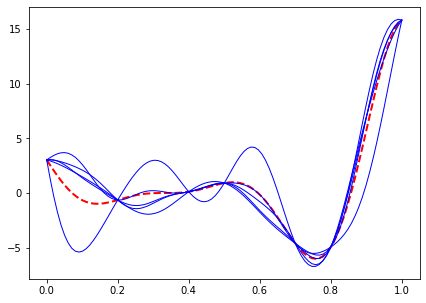

In [31]:
# Sample path
fig, ax = plt.subplots(figsize=(7,5))

# Generate realizations
samples = GP.realizations(5, X_test)

# True function
ax.plot(X_test,y_test,'r--',linewidth=2)

# Display realizations
for i in range(samples.shape[1]):
    ax.plot(X_test, samples[:,i],'b-', lw=1)

In [11]:
samples.shape

(100, 5)

In [34]:
GP.LOOCV()

array([3.54536516e+00, 5.73366809e-01, 1.98320543e-01, 1.26296299e-02,
       3.28207711e-02, 4.54618266e-02, 5.50950704e-02, 1.27775702e-02,
       6.26079246e+01])

In [35]:
error = np.zeros(X_train.shape[0])
for i in range(X_train.shape[0]):
    GP_cv = GPInterpolator(trend='Const', kernel='Gaussian',verbose=False)
    GP_cv.predict_only(np.delete(X_train, obj=i, axis=0), 
                       np.delete(y_train, obj=i, axis=0),
                      theta=GP.theta)
    y_pred, y_pred_SSqr = GP_cv.predict(X_train[[i],:])
    error[i] = (y_train[i,:]-y_pred)**2
print(np.sqrt(error) - np.sqrt(GP.LOOCV()))

[ 0.22208762  0.05762005  0.04947035 -0.00962407 -0.00322009 -0.00345872
 -0.01348892  0.03723515  0.57293192]


In [36]:
print(error)

[4.43103184e+00 6.63947822e-01 2.44829314e-01 1.05591156e-02
 3.16644060e-02 4.39988686e-02 4.89446911e-02 2.25819940e-02
 7.20028426e+01]


In [37]:
from sklearn.model_selection import cross_val_score
GP_sklearn = GPInterpolator(trend='Const', kernel='Gaussian',verbose=False)
scores = cross_val_score(GP_sklearn, X_train, y_train, 
                         cv=X_train.shape[0])

In [38]:
scores**2

array([5.21584571e+00, 1.26304167e+00, 7.98613315e-01, 1.69917582e-01,
       2.60237452e-03, 1.06094043e-03, 9.07778199e-04, 3.60080206e+00,
       2.74292097e+02])

In [18]:
obj = 7
GP_cv = GPInterpolator(trend='Linear', kernel='Matern-5_2',verbose=False)
GP_cv.fit(np.delete(X_train, obj=obj, axis=0), np.delete(y_train, obj=obj, axis=0))
y_pred, y_pred_SSqr = GP_cv.predict(X_train[[obj],:])
error = (y_train[obj,:]-y_pred)**2

In [19]:
error

array([451.18895209])

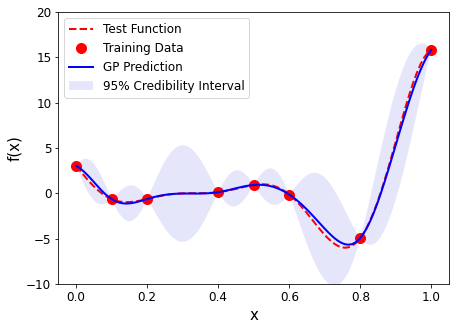

In [8]:
# Assess prediction results
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(X_test,y_test,'r--',linewidth=2,label='Test Function')
ax.plot(X_train,y_train,'ro',markerfacecolor='r', markersize=10, label='Training Data')
ax.plot(X_test,y_pred,'b-', lw=2, label='GP Prediction')
ax.fill_between(X_test.flatten(), y_pred-1.96*np.sqrt(y_pred_SSqr), 
                y_pred+1.96*np.sqrt(y_pred_SSqr),
                facecolor='lavender',label='95% Credibility Interval')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('f(x)', fontsize=15)
ax.set_ylim([-10,20])
ax.legend(loc="upper left",prop={'size': 12});

In [9]:
GP.score(X_test, y_test)

0.30071916776086643

### 1.2 Create 2D test

In [10]:
# 2D Test function
def Test_2D(X):
    """2D Test Function"""
    
    y = (1-X[:,0])**2 + 100*(X[:,1]-X[:,0]**2)**2
    
    return y

Generate training and testing samples

In [17]:
# Training data
sample_num = 30
lb, ub = np.array([-2, -1]), np.array([2, 3])
X_train = (ub-lb)*lhs(2, samples=sample_num) + lb

# Compute labels
y_train = Test_2D(X_train).reshape(-1,1)

# Test data
X1 = np.linspace(-2, 2, 20)
X2 = np.linspace(-1, 3, 20)
X1, X2 = np.meshgrid(X1, X2)
X_test = np.hstack((X1.reshape(-1,1), X2.reshape(-1,1)))
y_test = Test_2D(X_test)

Demonstrate training samples in 2D space

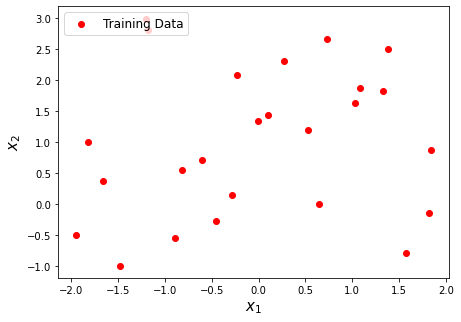

In [12]:
# Vislauzing training samples
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(X_train[:,0], X_train[:,1], c='r', label='Training Data')
ax.set_xlabel(r'$x_1$', fontsize=15)
ax.set_ylabel(r'$x_2$', fontsize=15)
ax.legend(loc="upper left",prop={'size': 12});

In [18]:
# GP model training
pipe = Pipeline([('scaler', MinMaxScaler()), 
         ('GP', GPInterpolator(trend='Linear', kernel='Matern-5_2', n_restarts=20))])
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('GP',
                 <GPInterpolator.GPInterpolator object at 0x000002228CD85AF0>)])

In [19]:
# GP model predicting
y_pred, y_pred_SSqr = pipe.predict(X_test)

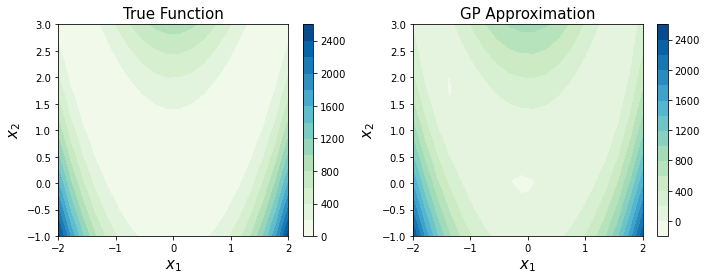

In [20]:
# Post-processing - Contour plot
fig, ax = plt.subplots(1, 2, figsize=(10,4))
title = ['True Function', 'GP Approximation']
display_y = [y_test, y_pred]

for i in range(2):
    h = ax[i].contourf(X_test[:,0].reshape(20,-1), 
                   X_test[:,1].reshape(20,-1), 
                   display_y[i].reshape(20,-1), levels=15, cmap='GnBu');
    ax[i].set_xlabel(r'$x_1$', fontsize=15)
    ax[i].set_ylabel(r'$x_2$', fontsize=15)
    ax[i].set_title(title[i], fontsize=15)
    fig.colorbar(h, ax=ax[i])
plt.tight_layout()

In [21]:
# Assess accuracy score
pipe.score(X_test, y_test)

29.300254068432594

### 1.3 Create 3D test

In [27]:
# Define test function
def Test_3D(X):
    """2D Test Function"""
    
    y = (1-X[:,0])**2 + 100*(X[:,1]-X[:,0]**2)**2 + \
        (1-X[:,1])**2 + 100*(X[:,2]-X[:,1]**2)**2
    
    return y

In [28]:
# Test data
lb, ub = np.array([-2, -1, -2]), np.array([2, 3, 2])
X_test = (ub-lb)*lhs(3, samples=500) + lb
y_test = Test_3D(X_test)

# Train data
X_train = (ub-lb)*lhs(3, samples=60) + lb
y_train = Test_3D(X_train).reshape(-1,1)

# Specify initial points
initial_theta = [-0.8, -0.78, -1.]

In [ ]:
# GP model training
pipe = Pipeline([('scaler', MinMaxScaler()), 
         ('GP', GPInterpolator(trend='Quadratic', n_restarts=50, optimizer='L-BFGS-B',
                              inital_point=initial_theta,
                              verbose=False))])
pipe.fit(X_train, y_train)

In [35]:
pipe[1].__dict__

{'n_restarts': 30,
 'optimizer': 'L-BFGS-B',
 'init_point': [-0.8, -0.78, -1.0],
 'kernel': 'Gaussian',
 'trend': 'Const',
 'nugget': 1e-10,
 'X': array([[0.66824255, 0.29421561, 0.60770644],
        [0.04187023, 0.85800459, 0.20394449],
        [0.98657227, 0.8609433 , 0.24579972],
        [0.0915312 , 0.78386415, 0.75959892],
        [0.42269368, 0.40648661, 0.01921103],
        [0.8434863 , 0.34424427, 0.56279826],
        [0.95553955, 0.50385965, 0.98346352],
        [0.27580049, 0.9664477 , 0.31765969],
        [0.30647651, 0.2267013 , 0.        ],
        [0.02304825, 0.99610534, 0.05190072],
        [0.10854705, 0.0905473 , 0.62830475],
        [0.2025837 , 0.82313046, 0.08303913],
        [0.06291474, 0.95562213, 0.5089296 ],
        [0.93239223, 0.03359873, 0.81516804],
        [0.94180687, 0.52929557, 0.5695245 ],
        [0.78696338, 0.61952152, 0.42003479],
        [0.4011491 , 0.65463024, 0.03341561],
        [0.77719317, 0.05347427, 0.89037252],
        [0.18127895, 0.247

In [30]:
# Assess accuracy score
pipe.score(X_test, y_test)

6.881184389527309